# Inventory-Adjusted Market Making Model

## 1. Introduction
This notebook implements an inventory-adjusted market-making strategy that actively manages inventory risk by skewing quotes based on the distance from a target inventory level. This represents a middle ground between naive fixed-spread strategies and fully optimal approaches like Avellaneda-Stoikov.

## 2. Model Assumptions
The inventory-adjusted market-making framework relies on the following assumptions:

* **Mid-price Dynamics**: The underlying asset price (fair value $V$) follows a Brownian Motion with no drift.
* **Fixed Base Spread**: The base spread $s$ is constant, but the actual quotes are adjusted based on inventory.
* **Poisson Order Arrivals**: Market buy and sell orders arrive according to independent Poisson processes with constant arrival rates.
* **Linear Inventory Adjustment**: Quotes are shifted linearly based on the deviation from target inventory $(q - q^*)$.
* **Target Inventory**: The market maker seeks to maintain inventory near a target level $q^*$.
* **Constant Volatility**: The asset's volatility ($\sigma$) is assumed to be constant throughout the entire trading horizon ($T$).

## 3. Key Parameters
Below are the primary inputs for the model along with their typical ranges and the specific values used in this simulation:

| Parameter | Description | Common Values | Current Value |
| :--- | :--- | :--- | :--- |
| **$\sigma$ (Sigma)** | **Volatility**: Asset price standard deviation. | Asset-dependent | `2.0` |
| **$s$ (Spread)** | **Base Spread**: Full bid-ask spread. | `0.02` to `1.0` | `0.2` |
| **$\delta$ (Delta)** | **Inventory Skew**: Adjustment per unit of inventory deviation. | `0.001` to `0.1` | `0.05` |
| **$q^*$ (q_target)** | **Target Inventory**: Desired inventory level. | `0` to `5` | `0` |
| **$\lambda_{buy}$** | **Buy Order Rate**: Poisson arrival rate for buys. | `50` to `200` | `100.0` |
| **$\lambda_{sell}$** | **Sell Order Rate**: Poisson arrival rate for sells. | `50` to `200` | `100.0` |
| **$T$** | **Time Horizon**: Normalized trading duration. | `1.0` | `1.0` |

## 4. Dynamics of the Fair Value
The model assumes the fair value (mid-price) $V_t$ follows a **Brownian Motion** (random walk without drift):

$$dV_t = \sigma dW_t$$

Where:
* **$\sigma$**: Constant volatility of the asset.
* **$W_t$**: A standard Wiener process.

## 5. Order Arrival Process
Buy and sell market orders arrive according to independent Poisson processes with constant rates:

* **Buy orders**: Arrive at rate $\lambda_{buy}$, hitting the ask price
* **Sell orders**: Arrive at rate $\lambda_{sell}$, hitting the bid price

The probability of an order arriving in a small time interval $dt$ is:

$$P(\text{buy order in } dt) = 1 - e^{-\lambda_{buy} \cdot dt}$$
$$P(\text{sell order in } dt) = 1 - e^{-\lambda_{sell} \cdot dt}$$

## 6. The Quote Placement Strategy
The market maker's quotes are adjusted based on the current inventory position relative to the target:

$$p^{bid} = V - \frac{s}{2} + \delta \cdot (q - q^*)$$
$$p^{ask} = V + \frac{s}{2} + \delta \cdot (q - q^*)$$

Where:
* **$V$**: Current fair value (mid-price)
* **$s$**: Base spread (full spread from bid to ask when at target inventory)
* **$\delta$**: Inventory skew parameter (adjustment per unit of inventory deviation)
* **$q$**: Current inventory position
* **$q^*$**: Target inventory level

### Interpretation:
* When $q > q^*$ (long inventory): Both bid and ask shift **up**, making it more attractive to sell (ask closer to mid) and less attractive to buy (bid further from mid)
* When $q < q^*$ (short inventory): Both bid and ask shift **down**, making it more attractive to buy (bid closer to mid) and less attractive to sell (ask further from mid)
* When $q = q^*$ (at target): Quotes are symmetric around the mid-price with half-spread of $s/2$

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample simulation

Performance Metrics:
Sharpe Ratio:  0.93
Sortino Ratio: 1.30
Max Drawdown:  11.85
Calmar Ratio:  1.34


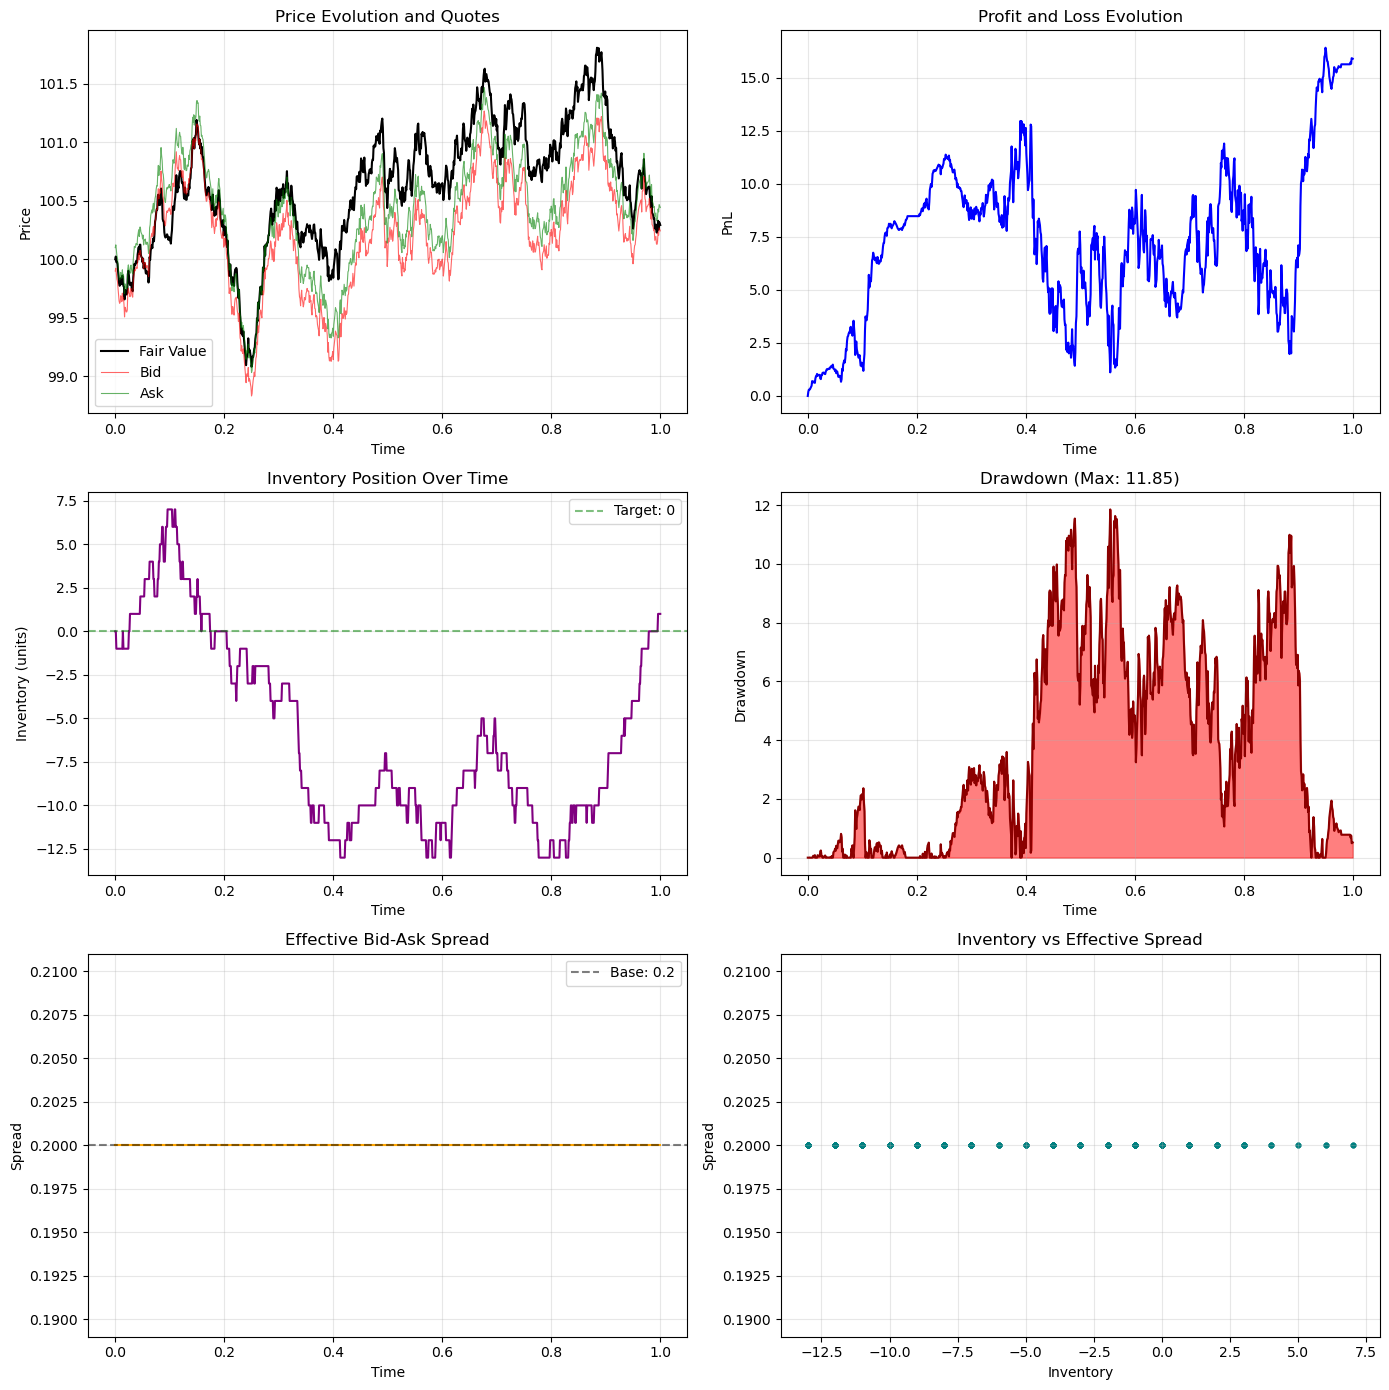

In [2]:
# Model Parameters
sigma = 2.0           # Volatility
base_spread = 0.2     # Base spread (s)
delta = 0.05          # Inventory skew parameter
q_target = 0          # Target inventory (q*)
lambda_buy = 100.0    # Buy order arrival rate
lambda_sell = 100.0   # Sell order arrival rate
T = 1.0               # Time horizon
n_steps = 1000        # Number of time steps
dt = T / n_steps      # Time step size
V0 = 100.0            # Initial fair value (mid-price)

# Initialize arrays
V = np.zeros(n_steps + 1)  # Fair value path
V[0] = V0
q = 0                      # Inventory
cash = 0.0                 # Cash position
pnl = np.zeros(n_steps + 1)  # PnL over time
inventory = np.zeros(n_steps + 1)  # Inventory over time
bid_prices = np.zeros(n_steps + 1)  # Bid quotes
ask_prices = np.zeros(n_steps + 1)  # Ask quotes
spreads = np.zeros(n_steps + 1)     # Effective spread over time

# Set initial quotes
inventory_adj = delta * (q - q_target)
bid_prices[0] = V0 - base_spread/2 + inventory_adj
ask_prices[0] = V0 + base_spread/2 + inventory_adj
spreads[0] = ask_prices[0] - bid_prices[0]
pnl[0] = 0.0
inventory[0] = 0

# Simulation loop
# np.random.seed(42)
for i in range(1, n_steps + 1):
    # Update fair value (Brownian motion)
    V[i] = V[i-1] + sigma * np.sqrt(dt) * np.random.randn()
    
    # Calculate inventory adjustment
    inventory_adj = delta * (q - q_target)
    
    # Set quotes with inventory adjustment
    bid = V[i] - base_spread/2 + inventory_adj
    ask = V[i] + base_spread/2 + inventory_adj
    bid_prices[i] = bid
    ask_prices[i] = ask
    spreads[i] = ask - bid
    
    # Check for buy orders (hitting our ask)
    prob_buy = 1 - np.exp(-lambda_buy * dt)
    if np.random.random() < prob_buy:
        q -= 1  # Sell one unit
        cash += ask  # Receive ask price
    
    # Check for sell orders (hitting our bid)
    prob_sell = 1 - np.exp(-lambda_sell * dt)
    if np.random.random() < prob_sell:
        q += 1  # Buy one unit
        cash -= bid  # Pay bid price
    
    # Update PnL and inventory tracking
    pnl[i] = cash + q * V[i]
    inventory[i] = q

# Calculate performance metrics
returns = np.diff(pnl)
mu = np.mean(returns) * n_steps  # Annualized return
vol = np.std(returns) * np.sqrt(n_steps)  # Annualized volatility

sharpe = mu / vol if vol != 0 else 0

downside_returns = returns[returns < 0]
downside_std = np.std(downside_returns) * np.sqrt(n_steps) if len(downside_returns) > 0 else 1e-10
sortino = mu / downside_std if downside_std != 0 else 0

cummax = np.maximum.accumulate(pnl)
drawdown = cummax - pnl
max_dd = np.max(drawdown)
calmar = mu / max_dd if max_dd != 0 else 0

print("Performance Metrics:")
print("====================")
print(f"Sharpe Ratio:  {sharpe:.2f}")
print(f"Sortino Ratio: {sortino:.2f}")
print(f"Max Drawdown:  {max_dd:.2f}")
print(f"Calmar Ratio:  {calmar:.2f}")

# Visualization
fig, axes = plt.subplots(3, 2, figsize=(14, 14))

time_grid = np.linspace(0, T, n_steps + 1)

# Plot 1: Fair value evolution with bid/ask
axes[0, 0].plot(time_grid, V, label='Fair Value', linewidth=1.5, color='black')
axes[0, 0].plot(time_grid, bid_prices, label='Bid', linewidth=0.8, alpha=0.6, color='red')
axes[0, 0].plot(time_grid, ask_prices, label='Ask', linewidth=0.8, alpha=0.6, color='green')
axes[0, 0].set_xlabel('Time')
axes[0, 0].set_ylabel('Price')
axes[0, 0].set_title('Price Evolution and Quotes')
axes[0, 0].legend()
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: PnL evolution
axes[0, 1].plot(time_grid, pnl, linewidth=1.5, color='blue')
axes[0, 1].set_xlabel('Time')
axes[0, 1].set_ylabel('PnL')
axes[0, 1].set_title('Profit and Loss Evolution')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Inventory evolution
axes[1, 0].plot(time_grid, inventory, linewidth=1.5, color='purple')
axes[1, 0].axhline(y=q_target, color='green', linestyle='--', alpha=0.5, label=f'Target: {q_target}')
axes[1, 0].set_xlabel('Time')
axes[1, 0].set_ylabel('Inventory (units)')
axes[1, 0].set_title('Inventory Position Over Time')
axes[1, 0].legend()
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Drawdown
axes[1, 1].fill_between(time_grid, 0, drawdown, alpha=0.5, color='red')
axes[1, 1].plot(time_grid, drawdown, linewidth=1.5, color='darkred')
axes[1, 1].set_xlabel('Time')
axes[1, 1].set_ylabel('Drawdown')
axes[1, 1].set_title(f'Drawdown (Max: {max_dd:.2f})')
axes[1, 1].grid(True, alpha=0.3)

# Plot 5: Effective spread evolution
axes[2, 0].plot(time_grid, spreads, linewidth=1.5, color='orange')
axes[2, 0].axhline(y=base_spread, color='black', linestyle='--', alpha=0.5, label=f'Base: {base_spread}')
axes[2, 0].set_xlabel('Time')
axes[2, 0].set_ylabel('Spread')
axes[2, 0].set_title('Effective Bid-Ask Spread')
axes[2, 0].legend()
axes[2, 0].grid(True, alpha=0.3)

# Plot 6: Inventory vs Spread (scatter)
axes[2, 1].scatter(inventory, spreads, alpha=0.3, s=10, color='teal')
axes[2, 1].set_xlabel('Inventory')
axes[2, 1].set_ylabel('Spread')
axes[2, 1].set_title('Inventory vs Effective Spread')
axes[2, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Monte Carlo Analysis

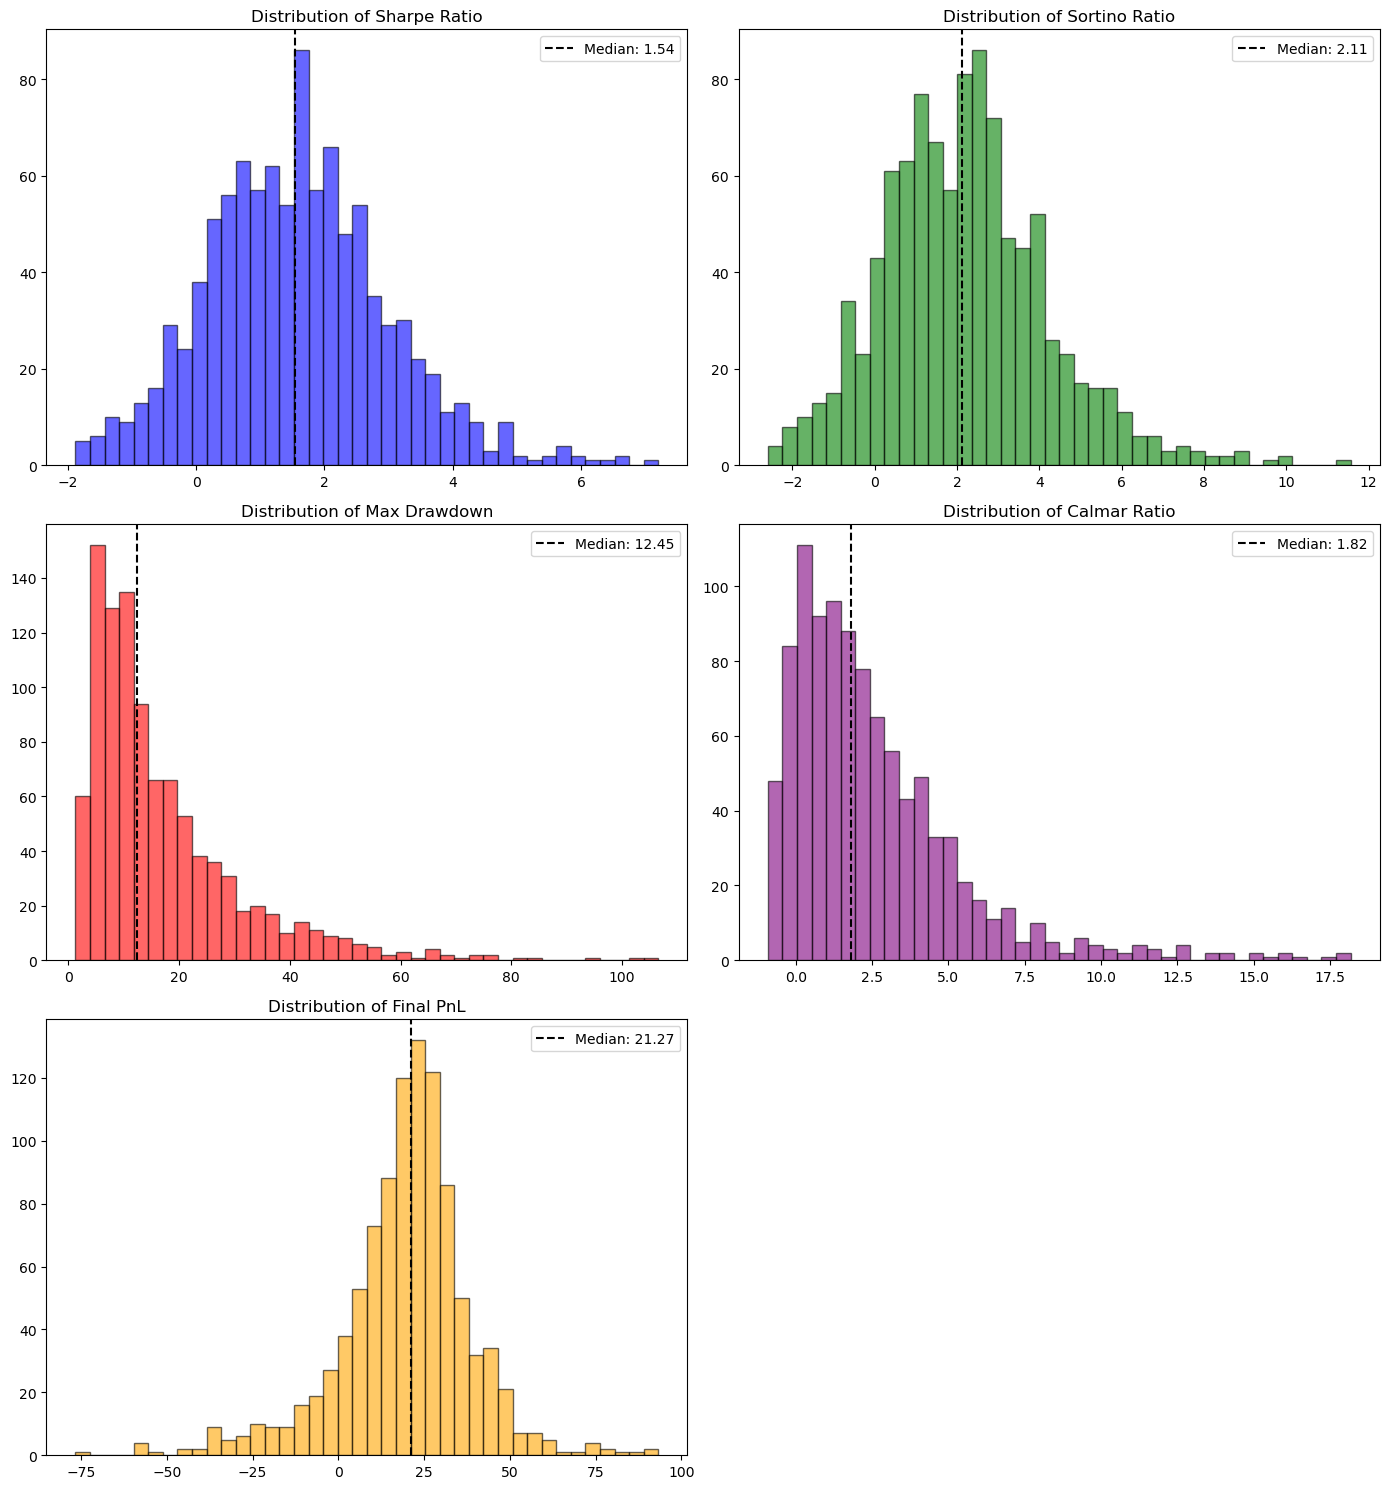

In [3]:
# Monte Carlo Simulation Parameters
N_SIMS = 1000  # Number of simulations

def run_single_simulation():
    """
    Run a single simulation of the inventory-adjusted market-making strategy.
    Returns performance metrics: sharpe, sortino, max_dd, calmar, final_pnl
    """
    # Initialize state
    V = np.zeros(n_steps + 1)
    V[0] = V0
    q = 0
    cash = 0.0
    pnl = np.zeros(n_steps + 1)
    
    # Simulation loop
    for i in range(1, n_steps + 1):
        # Update fair value (Brownian motion)
        V[i] = V[i-1] + sigma * np.sqrt(dt) * np.random.randn()
        
        # Calculate inventory adjustment
        inventory_adj = delta * (q - q_target)
        
        # Set quotes with inventory adjustment
        bid = V[i] - base_spread/2 + inventory_adj
        ask = V[i] + base_spread/2 + inventory_adj
        
        # Check for buy orders (hitting our ask)
        prob_buy = 1 - np.exp(-lambda_buy * dt)
        if np.random.random() < prob_buy:
            q -= 1
            cash += ask
        
        # Check for sell orders (hitting our bid)
        prob_sell = 1 - np.exp(-lambda_sell * dt)
        if np.random.random() < prob_sell:
            q += 1
            cash -= bid
        
        # Update PnL
        pnl[i] = cash + q * V[i]
    
    # Calculate metrics
    returns = np.diff(pnl)
    mu = np.mean(returns) * n_steps
    vol = np.std(returns) * np.sqrt(n_steps)
    
    sharpe = mu / vol if vol != 0 else 0
    
    downside_returns = returns[returns < 0]
    downside_std = np.std(downside_returns) * np.sqrt(n_steps) if len(downside_returns) > 0 else 1e-10
    sortino = mu / downside_std if downside_std != 0 else 0
    
    max_dd = np.max(np.maximum.accumulate(pnl) - pnl)
    calmar = mu / max_dd if max_dd != 0 else 0
    
    return sharpe, sortino, max_dd, calmar, pnl[-1]

# Execute Monte Carlo
results = np.array([run_single_simulation() for _ in range(N_SIMS)])
sharpes, sortinos, max_dds, calmars, final_pnls = results.T

# Visualization of Distributions
fig, axes = plt.subplots(3, 2, figsize=(14, 15))
metrics = [
    (sharpes, 'Sharpe Ratio', 'blue'),
    (sortinos, 'Sortino Ratio', 'green'),
    (max_dds, 'Max Drawdown', 'red'),
    (calmars, 'Calmar Ratio', 'purple'),
    (final_pnls, 'Final PnL', 'orange')
]

# Plot each metric
for i, (data, title, color) in enumerate(metrics):
    ax = axes.flatten()[i]
    ax.hist(data, bins=40, color=color, alpha=0.6, edgecolor='black')
    ax.axvline(np.median(data), color='black', linestyle='--', label=f'Median: {np.median(data):.2f}')
    ax.set_title(f'Distribution of {title}')
    ax.legend()

# Remove the empty subplot (6th plot)
fig.delaxes(axes[2, 1])

plt.tight_layout()
plt.show()

# Parameter Sensitivity Analysis

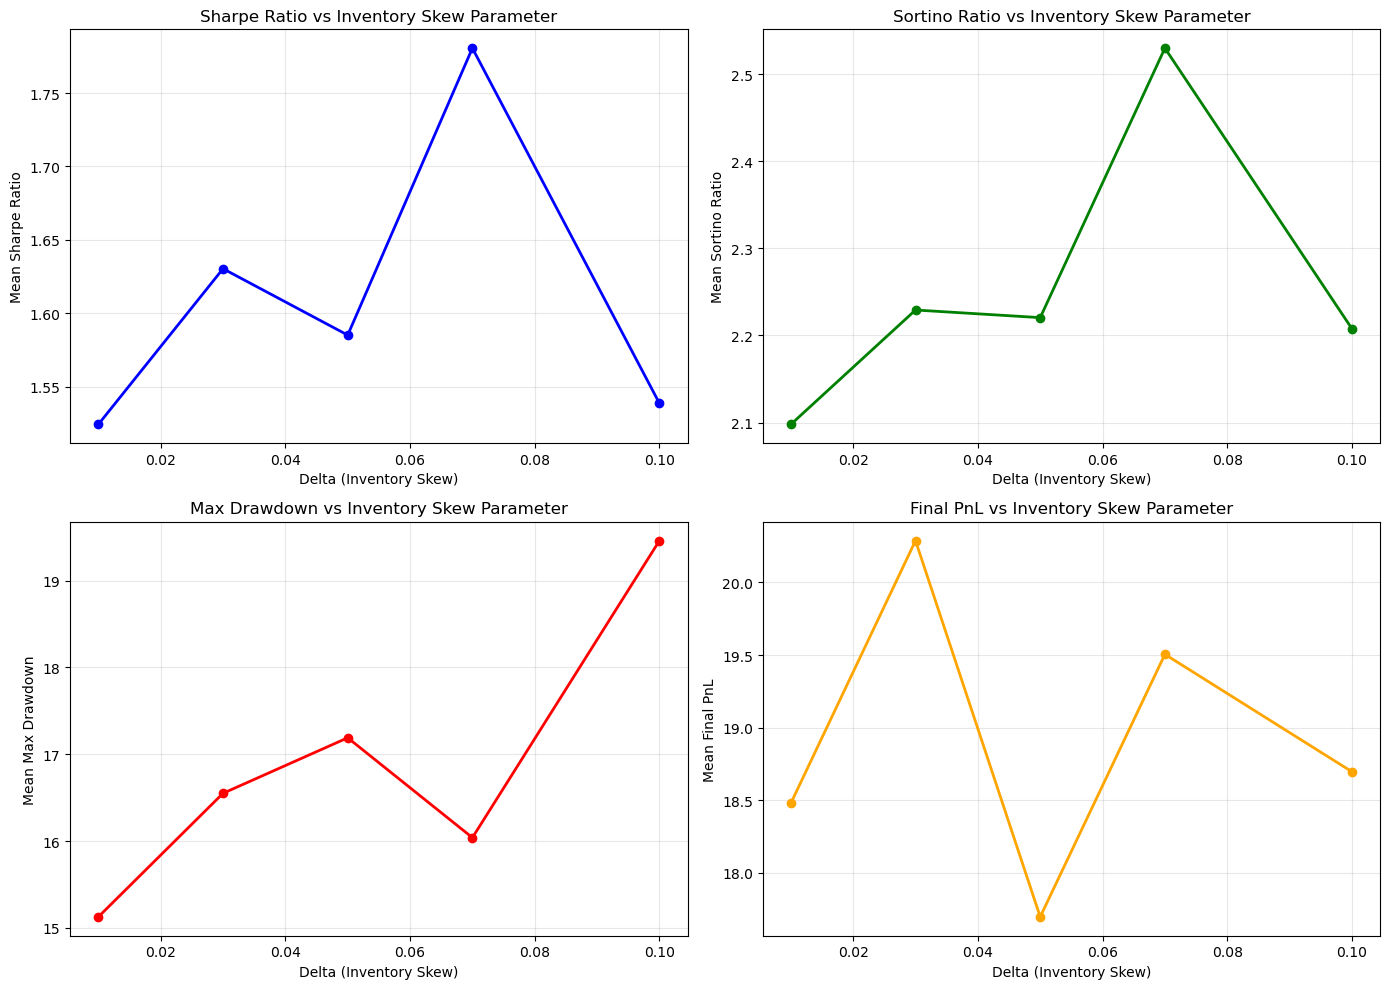

In [4]:
# Analyze impact of different delta (inventory skew) values
delta_values = [0.01, 0.03, 0.05, 0.07, 0.10]
n_sims_sensitivity = 200

results_by_delta = {}

for delta_test in delta_values:
    # Temporarily override delta
    delta_orig = delta
    delta = delta_test
    
    # Run simulations
    sim_results = np.array([run_single_simulation() for _ in range(n_sims_sensitivity)])
    results_by_delta[delta_test] = sim_results
    
    # Restore original delta
    delta = delta_orig

# Visualization
fig, axes = plt.subplots(2, 2, figsize=(14, 10))

# Extract metrics for each delta
mean_sharpes = [np.mean(results_by_delta[d][:, 0]) for d in delta_values]
mean_sortinos = [np.mean(results_by_delta[d][:, 1]) for d in delta_values]
mean_max_dds = [np.mean(results_by_delta[d][:, 2]) for d in delta_values]
mean_final_pnls = [np.mean(results_by_delta[d][:, 4]) for d in delta_values]

# Plot 1: Sharpe vs Delta
axes[0, 0].plot(delta_values, mean_sharpes, marker='o', linewidth=2, color='blue')
axes[0, 0].set_xlabel('Delta (Inventory Skew)')
axes[0, 0].set_ylabel('Mean Sharpe Ratio')
axes[0, 0].set_title('Sharpe Ratio vs Inventory Skew Parameter')
axes[0, 0].grid(True, alpha=0.3)

# Plot 2: Sortino vs Delta
axes[0, 1].plot(delta_values, mean_sortinos, marker='o', linewidth=2, color='green')
axes[0, 1].set_xlabel('Delta (Inventory Skew)')
axes[0, 1].set_ylabel('Mean Sortino Ratio')
axes[0, 1].set_title('Sortino Ratio vs Inventory Skew Parameter')
axes[0, 1].grid(True, alpha=0.3)

# Plot 3: Max Drawdown vs Delta
axes[1, 0].plot(delta_values, mean_max_dds, marker='o', linewidth=2, color='red')
axes[1, 0].set_xlabel('Delta (Inventory Skew)')
axes[1, 0].set_ylabel('Mean Max Drawdown')
axes[1, 0].set_title('Max Drawdown vs Inventory Skew Parameter')
axes[1, 0].grid(True, alpha=0.3)

# Plot 4: Final PnL vs Delta
axes[1, 1].plot(delta_values, mean_final_pnls, marker='o', linewidth=2, color='orange')
axes[1, 1].set_xlabel('Delta (Inventory Skew)')
axes[1, 1].set_ylabel('Mean Final PnL')
axes[1, 1].set_title('Final PnL vs Inventory Skew Parameter')
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# References

1. Avellaneda, M., & Stoikov, S. (2008). "High-frequency trading in a limit order book." Quantitative Finance, 8(3), 217-224.

2. Cartea, Á., Jaimungal, S., & Penalva, J. (2015). "Algorithmic and High-Frequency Trading." Cambridge University Press.

3. Lehalle, C. A., & Laruelle, S. (2018). "Market Microstructure in Practice." World Scientific Publishing.

4. Gueant, O. (2016). "The Financial Mathematics of Market Liquidity: From Optimal Execution to Market Making." Chapman and Hall/CRC.

5. Spooner, T., Savani, R., & Ramasubramanian, A. (2018). "Market Making via Reinforcement Learning." arXiv preprint arXiv:1804.04216.